# Flow Matching on $\mathrm{SO}(3)$
In this notebook, we perform flow matching on the rotation group $\mathrm{SO}(3)$, corresponding to Figure 2 in ["Flow Matching on Lie Groups"](https://arxiv.org/abs/2504.00494).

In [1]:
import torch
import numpy as np
from lieflow.groups import SO3
from lieflow.models import (
    get_model_FM,
    LogarithmicDistance
)
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
plt.rcParams.update({
    "text.usetex": False,  # Disable LaTeX
    "font.family": "serif",
    "font.serif": ["DejaVu Serif", "Times New Roman", "serif"],
    "font.size": 10.0
})
from tqdm.notebook import tqdm

In [2]:
so3 = SO3()

In [3]:
generate_videos = True

# Distributions

In [4]:
def generate_line(N, d=0., w=np.pi/4, horizontal=True, ε=0.05):
    if horizontal:
        d_ε = d + np.random.randn(N) * ε
        cos_y = np.cos(d_ε)
        sin_y = np.sin(d_ε)
        R_y = np.moveaxis(np.array((
            (cos_y, np.zeros(N), -sin_y),
            (np.zeros(N), np.ones(N), np.zeros(N)),
            (sin_y, np.zeros(N), cos_y),
        )),
        (0, 1),
        (-2, -1)
        )
        θs_z = 2 * w * (np.random.rand(N) - 0.5)
        cos_z = np.cos(θs_z)
        sin_z = np.sin(θs_z)
        R_z = np.moveaxis(np.array((
            (cos_z, -sin_z, np.zeros(N)),
            (sin_z, cos_z, np.zeros(N)),
            (np.zeros(N), np.zeros(N), np.ones(N)),
        )),
        (0, 1),
        (-2, -1)
        )
        Rs = torch.Tensor(R_z @ R_y)
    else:
        turn_ε = -np.pi/2 + np.random.randn(N) * ε
        cos_turn = np.cos(turn_ε)
        sin_turn = np.sin(turn_ε)
        R_turn = np.moveaxis(np.array((
            (np.ones(N), np.zeros(N), np.zeros(N)),
            (np.zeros(N), cos_turn, -sin_turn),
            (np.zeros(N), sin_turn, cos_turn),
        )),
        (0, 1),
        (-2, -1)
        )
        d_ε = d + np.random.randn(N) * ε
        cos_z = np.cos(d_ε)
        sin_z = np.sin(d_ε)
        R_z = np.moveaxis(np.array((
            (cos_z, -sin_z, np.zeros(N)),
            (sin_z, cos_z, np.zeros(N)),
            (np.zeros(N), np.zeros(N), np.ones(N)),
        )),
        (0, 1),
        (-2, -1)
        )
        θs_y = 2 * w * (np.random.rand(N) - 0.5)
        cos_y = np.cos(θs_y)
        sin_y = np.sin(θs_y)
        R_y = np.moveaxis(np.array((
            (cos_y, np.zeros(N), -sin_y),
            (np.zeros(N), np.ones(N), np.zeros(N)),
            (sin_y, np.zeros(N), cos_y),
        )),
        (0, 1),
        (-2, -1)
        )
        Rs = torch.Tensor(R_z @ R_y @ R_turn)
    return Rs

def generate_circle(N, d=0., w=np.pi/4, ε=0.05, gap=0.):
    w_ε = w + np.random.randn(N) * ε
    cos_y = np.cos(w_ε)
    sin_y = np.sin(w_ε)
    R_y = np.moveaxis(np.array((
        (cos_y, np.zeros(N), -sin_y),
        (np.zeros(N), np.ones(N), np.zeros(N)),
        (sin_y, np.zeros(N), cos_y),
    )),
    (0, 1),
    (-2, -1)
    )
    θs_x = (np.random.rand(N) * (2 - gap) - (1.5 - gap)) * np.pi
    cos_x = np.cos(θs_x)
    sin_x = np.sin(θs_x)
    R_x = np.moveaxis(np.array((
        (np.ones(N), np.zeros(N), np.zeros(N)),
        (np.zeros(N), cos_x, -sin_x),
        (np.zeros(N), sin_x, cos_x),
    )),
    (0, 1),
    (-2, -1)
    )
    d_ε = d + np.random.randn(N) * ε
    cos_z = np.cos(d_ε)
    sin_z = np.sin(d_ε)
    R_z = np.moveaxis(np.array((
        (cos_z, -sin_z, np.zeros(N)),
        (sin_z, cos_z, np.zeros(N)),
        (np.zeros(N), np.zeros(N), np.ones(N)),
    )),
    (0, 1),
    (-2, -1)
    )
    return torch.Tensor(R_z @ R_x @ R_y)

In [5]:
tests = ("horizontal_line_to_vertical_line", "vertical_line_to_circle")

In [6]:
def data_generator(test, ε=0.04):
    match test:
        case "horizontal_line_to_vertical_line":
            generate_R_0 = lambda n: generate_line(n, d=-np.pi/6, w=np.pi/12, horizontal=True, ε=ε)
            generate_R_1 = lambda n: generate_line(n, d=np.pi/6, w=np.pi/12, horizontal=False, ε=ε)
        case "vertical_line_to_vertical_line":
            generate_R_0 = lambda n: generate_line(n, d=-np.pi/6, w=np.pi/12, horizontal=False, ε=ε)
            generate_R_1 = lambda n: generate_line(n, d=np.pi/6, w=np.pi/12, horizontal=False, ε=ε)
        case "vertical_line_to_circle":
            generate_R_0 = lambda n: generate_line(n, d=-np.pi/6, w=np.pi/12, horizontal=False, ε=ε)
            generate_R_1 = lambda n: generate_circle(n, d=np.pi/6, w=np.pi/12, gap=0., ε=ε)
        case "circle_to_circle":
            generate_R_0 = lambda n: generate_circle(n, w=np.pi/20, ε=ε)
            generate_R_1 = lambda n: generate_circle(n, w=np.pi/6, ε=ε)
    return generate_R_0, generate_R_1

# Models

## Training

In [7]:
EPSILON = 0.01
N = 2**14
BATCH_SIZE = 2**10
EPOCHS = len(tests) * [50]
WEIGHT_DECAY = 0.
LEARNING_RATE = 1e-2
H = 64 # Width
L = 3 # Number of layers is L + 2
device = "cpu"

In [8]:
def train_model(R_0s, R_1s, epochs, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY):
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(R_0s, R_1s), batch_size=batch_size, shuffle=True
    )

    model_FM = get_model_FM(so3, H=H, L=L).to(device)
    print("Number of parameters: ", model_FM.parameter_count)
    optimizer_FM = torch.optim.Adam(model_FM.parameters(), learning_rate, weight_decay=weight_decay)
    loss = LogarithmicDistance(torch.Tensor([1., 1., 1.]))

    losses_FM = np.zeros(epochs)
    for i in tqdm(range(epochs)):
        losses_FM[i] = model_FM.train_network(device, train_loader, optimizer_FM, loss)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(losses_FM)
    ax.set_title("Batch Loss Flow Matching")
    ax.set_xscale("log")
    ax.set_yscale("log")

    return model_FM

horizontal_line_to_vertical_line
Number of parameters:  5059


  0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

vertical_line_to_circle
Number of parameters:  5059


  0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Training:   0%|                                                                   | 0/16 [00:00<?, ?batch/s]

Error in callback <function _draw_all_if_interactive at 0x7f1224636f20> (for post_execute), with arguments args (),kwargs {}:


ValueError: Data has no positive values, and therefore cannot be log-scaled.

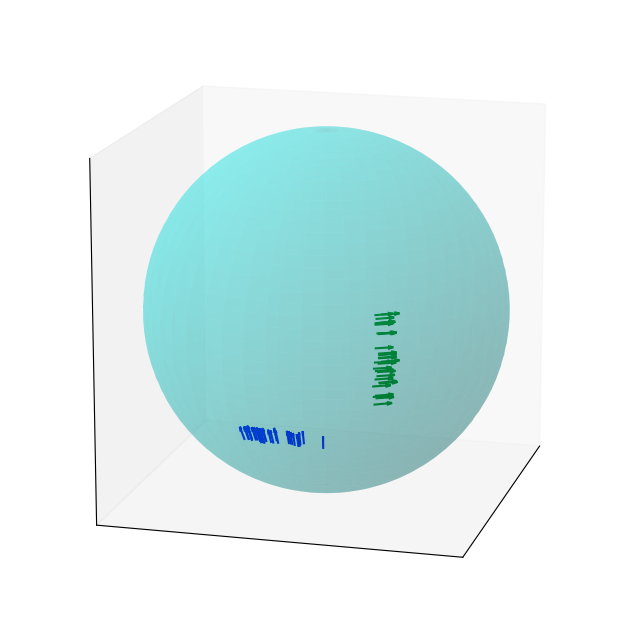

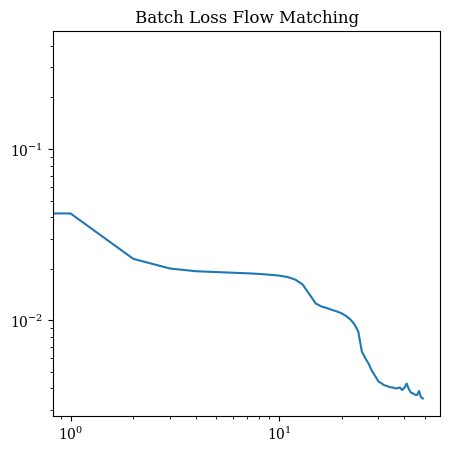

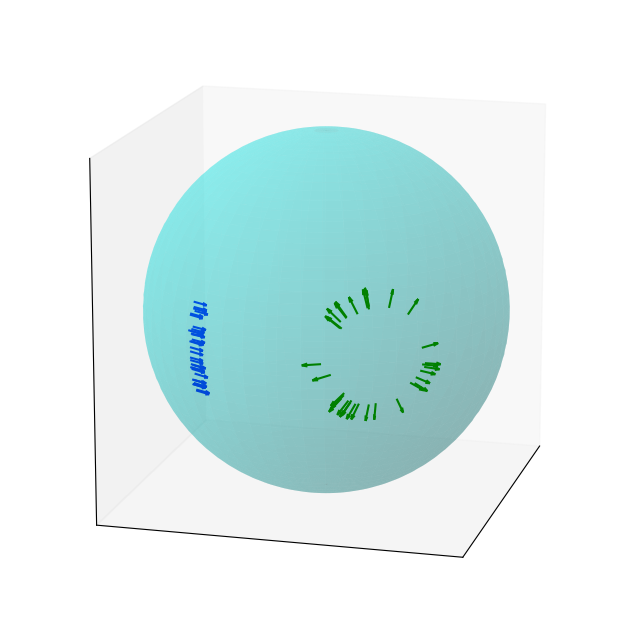

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 500x500 with 1 Axes>

In [9]:
theta = np.linspace(0, np.pi, 50)
phi = np.linspace(0, 2 * np.pi, 100)
theta, phi = np.meshgrid(theta, phi)

x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)
r = 1.01

models_FM = {}
for i, test in enumerate(tests):
    print(test)
    generate_R_0, generate_R_1 = data_generator(test, ε=EPSILON)

    R_0s = generate_R_0(N)
    R_1s = generate_R_1(N)

    q_ref = torch.Tensor([
    [1., 0., 0.],
    [0., 0., 1.]
    ]).T
    q_0 = R_0s @ q_ref
    q_1 = R_1s @ q_ref

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=15, azim=15)
    ax.plot_surface(x, y, z, color='cyan', alpha=0.25, edgecolor=None)
    ax.quiver(
        r*q_0[:32, 0, 0], r*q_0[:32, 1, 0], r*q_0[:32, 2, 0],
        q_0[:32, 0, 1], q_0[:32, 1, 1], q_0[:32, 2, 1],
        length=0.1, color="blue"
    )
    ax.quiver(
        r*q_1[:32, 0, 0], r*q_1[:32, 1, 0], r*q_1[:32, 2, 0],
        q_1[:32, 0, 1], q_1[:32, 1, 1], q_1[:32, 2, 1],
        length=0.1, color="green"
    )

    ax.set_xlim([-1, 1])
    ax.set_xticks([])
    ax.set_ylim([-1, 1])
    ax.set_yticks([])
    ax.set_zlim([-1, 1])
    ax.set_zticks([])
    ax.set_aspect("equal");

    models_FM[test] = train_model(R_0s, R_1s, epochs=EPOCHS[i], batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE,
                                  weight_decay=WEIGHT_DECAY)

## Testing

In [10]:
def create_animations(tests, models_FM, N=2**5):
    # Forward flow
    R_0s_test = {}
    R_ts_test = {}
    for test in tests:
        generate_R_0, _ = data_generator(test, ε=EPSILON)
        R_0s_test[test] = generate_R_0(N).to(device)
        R_ts_test[test] = R_0s_test[test].detach().clone()
        
        models_FM[test].eval()

    t = 0
    N_steps = 120
    Δt = 1. / N_steps

    for test in tests:
        metadata = {'title': f'Flow Matching SO(3) {test}', 'artist': 'Matplotlib'}
        writer = FFMpegWriter(fps=30, metadata=metadata)

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=15, azim=15)
        ax.plot_surface(x, y, z, color='cyan', alpha=0.25, edgecolor=None)
        quiver = ax.quiver([], [], [], [], [], [])

        ax.set_xlim([-1, 1])
        ax.set_xticks([])
        ax.set_ylim([-1, 1])
        ax.set_yticks([])
        ax.set_zlim([-1, 1])
        ax.set_zticks([])
        ax.set_aspect("equal")
        with writer.saving(fig, f"output/flow_matching_SO3_{test}.mp4", dpi=150):
            R_ts_test_plot = R_ts_test[test].to("cpu")
            q_ts = R_ts_test_plot @ q_ref

            quiver.remove()
            quiver = ax.quiver(
                r*q_ts[:, 0, 0], r*q_ts[:, 1, 0], r*q_ts[:, 2, 0],
                q_ts[:, 0, 1], q_ts[:, 1, 1], q_ts[:, 2, 1],
                length=0.25
            )
            writer.grab_frame()
            for frame in tqdm(range(N_steps)):
                t = frame * Δt
                with torch.no_grad():
                    R_ts_test[test] = models_FM[test].step(R_ts_test[test], torch.Tensor([t])[..., None], Δt)
                R_ts_test_plot = R_ts_test[test].to("cpu")
                q_ts = R_ts_test_plot @ q_ref

                quiver.remove()
                quiver = ax.quiver(
                    r*q_ts[:, 0, 0], r*q_ts[:, 1, 0], r*q_ts[:, 2, 0],
                    q_ts[:, 0, 1], q_ts[:, 1, 1], q_ts[:, 2, 1],
                    length=0.25
                )
                writer.grab_frame()
            writer.grab_frame()
    
    # Backward flow
    R_1s_test = {}
    R_ts_test = {}
    for test in tests:
        _, generate_R_1 = data_generator(test, ε=EPSILON)
        R_1s_test[test] = generate_R_1(N).to(device)
        R_ts_test[test] = R_1s_test[test].detach().clone()
        
        models_FM[test].eval()

    t = 0
    N_steps = 120
    Δt = 1. / N_steps

    for test in tests:
        metadata = {'title': f'Flow Matching SO(3) {test}', 'artist': 'Matplotlib'}
        writer = FFMpegWriter(fps=30, metadata=metadata)

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=15, azim=15)
        ax.plot_surface(x, y, z, color='cyan', alpha=0.25, edgecolor=None)
        quiver = ax.quiver([], [], [], [], [], [])

        ax.set_xlim([-1, 1])
        ax.set_xticks([])
        ax.set_ylim([-1, 1])
        ax.set_yticks([])
        ax.set_zlim([-1, 1])
        ax.set_zticks([])
        ax.set_aspect("equal")
        with writer.saving(fig, f"output/flow_matching_SO3_{test}_backwards.mp4", dpi=150):
            R_ts_test_plot = R_ts_test[test].to("cpu")
            q_ts = R_ts_test_plot @ q_ref

            quiver.remove()
            quiver = ax.quiver(
                r*q_ts[:, 0, 0], r*q_ts[:, 1, 0], r*q_ts[:, 2, 0],
                q_ts[:, 0, 1], q_ts[:, 1, 1], q_ts[:, 2, 1],
                length=0.25
            )
            writer.grab_frame()
            for frame in tqdm(range(N_steps)):
                t = 1. - frame * Δt
                with torch.no_grad():
                    R_ts_test[test] = models_FM[test].step_back(R_ts_test[test], torch.Tensor([t])[..., None], Δt)
                R_ts_test_plot = R_ts_test[test].to("cpu")
                q_ts = R_ts_test_plot @ q_ref

                quiver.remove()
                quiver = ax.quiver(
                    r*q_ts[:, 0, 0], r*q_ts[:, 1, 0], r*q_ts[:, 2, 0],
                    q_ts[:, 0, 1], q_ts[:, 1, 1], q_ts[:, 2, 1],
                    length=0.25
                )
                writer.grab_frame()
            writer.grab_frame()

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

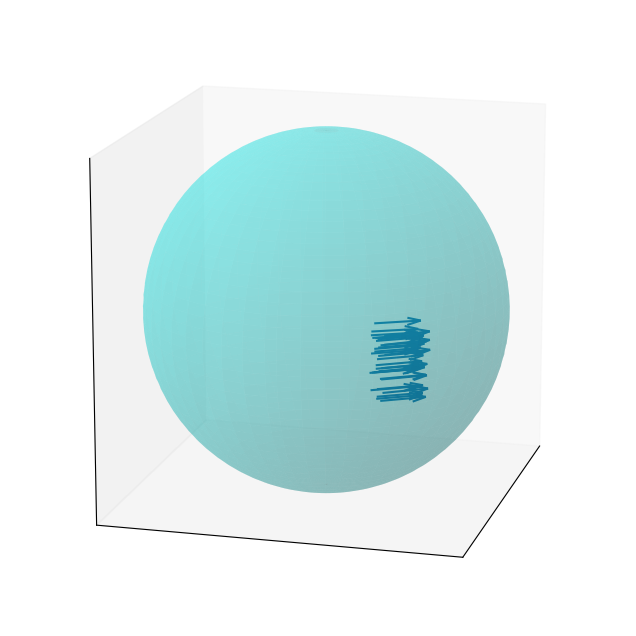

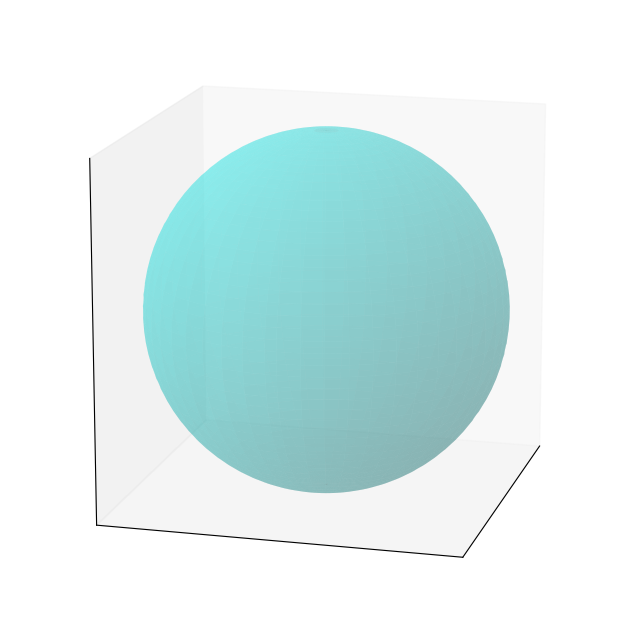

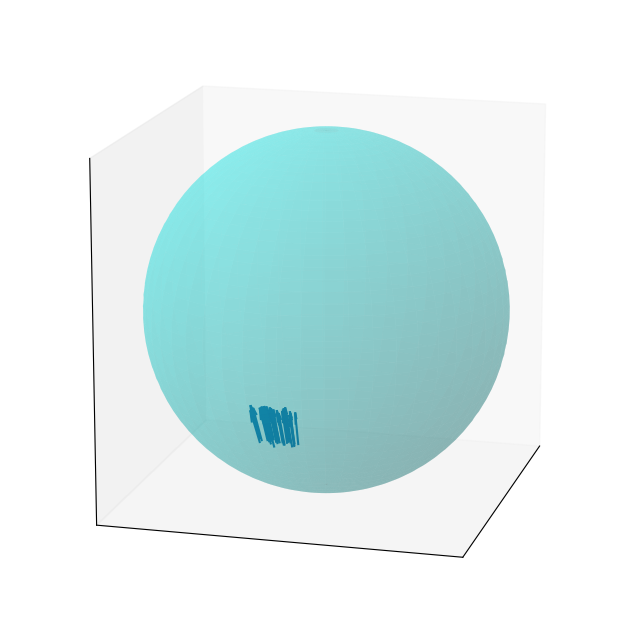

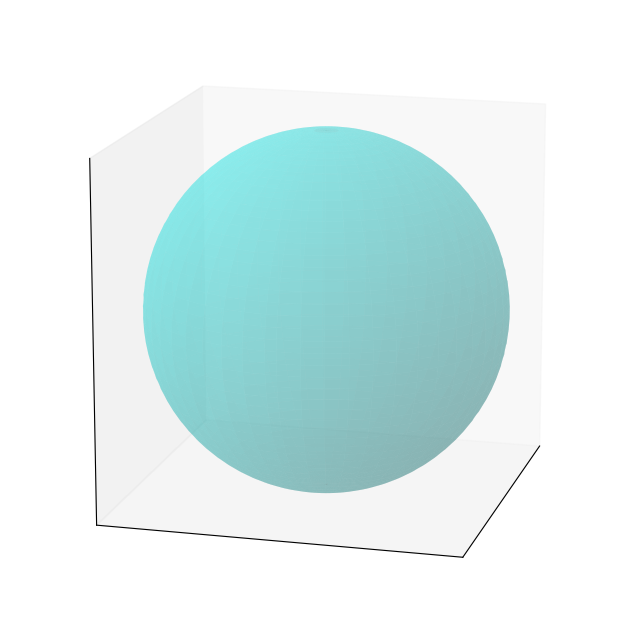

In [11]:
if generate_videos:
    create_animations(tests, models_FM, N=2**5)

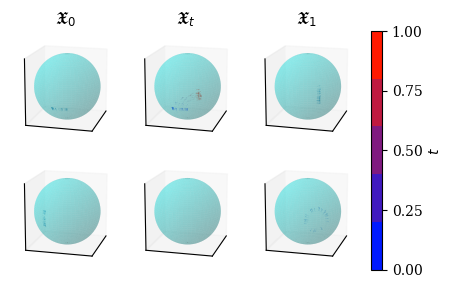

In [12]:
t = 0
N_steps = 240
Δt = 1. / N_steps
N_show = 5
N_skip = int(N_steps / (N_show-1))

N_models = len(tests)
N_samples = 32

R_0s_test = {}
R_1s_test = {}
R_ts_test = {}
for test in tests:
    generate_R_0, generate_R_1 = data_generator(test, ε=EPSILON)
    R_0s_test[test] = generate_R_0(N_samples).to(device)
    R_1s_test[test] = generate_R_1(N_samples).to(device)
    R_ts_test[test] = R_0s_test[test].detach().clone()
    
    models_FM[test].eval()

fig = plt.figure(figsize=(4.8, 1.6 * N_models * 3/3.1))
gs = gridspec.GridSpec(N_models, 4, width_ratios=[1, 1, 1, 0.1], height_ratios=N_models * [1.], wspace=0.1, hspace=0.1)
cax = fig.add_subplot(gs[:, 3])

ax = []
for i in range(N_models):
    ax.append([])
    for j in range(3):
        a = fig.add_subplot(gs[i, j], projection="3d")
        a.view_init(elev=15, azim=15)
        a.plot_surface(x, y, z, color='cyan', alpha=0.25, edgecolor=None)

        a.set_xlim([-1, 1])
        a.set_xticks([])
        a.set_ylim([-1, 1])
        a.set_yticks([])
        a.set_zlim([-1, 1])
        a.set_zticks([])
        a.set_aspect("equal")
        ax[i].append(a)
        
ax[0][0].set_title(r"$\mathfrak{X}_0$")
ax[0][1].set_title(r"$\mathfrak{X}_t$")
ax[0][2].set_title(r"$\mathfrak{X}_1$")
Δc = 1 / (N_show - 1)
colors = [(j * Δc, 0.1, 1 - j * Δc) for j in range(N_show)]
cmap = mcolors.ListedColormap(colors)
for i, test in enumerate(tests):
    k = 0

    q_0s = R_0s_test[test][:N_samples] @ q_ref
    q_1s = R_1s_test[test][:N_samples] @ q_ref

    ax[i][0].quiver(
        r*q_0s[:, 0, 0], r*q_0s[:, 1, 0], r*q_0s[:, 2, 0],
        q_0s[:, 0, 1], q_0s[:, 1, 1], q_0s[:, 2, 1],
        length=0.1, linewidths=0.05
    )
    ax[i][2].quiver(
        r*q_1s[:, 0, 0], r*q_1s[:, 1, 0], r*q_1s[:, 2, 0],
        q_1s[:, 0, 1], q_1s[:, 1, 1], q_1s[:, 2, 1],
        length=0.1, linewidths=0.05
    )

    alpha = 1
    N_samples_shown = N_samples
    for j in range(N_steps+1):
        t = j * Δt
        if j == N_steps:
            alpha = 1
            N_samples_shown = N_samples
        with torch.no_grad():
            R_ts_test[test] = models_FM[test].step(R_ts_test[test], torch.Tensor([t]), torch.Tensor([Δt]))

        if j % N_skip == 0:
            R_ts_test_plot = R_ts_test[test].to("cpu")
            q_ts = R_ts_test_plot[:N_samples_shown] @ q_ref

            im = ax[i][1].quiver(
                r*q_ts[:, 0, 0], r*q_ts[:, 1, 0], r*q_ts[:, 2, 0],
                q_ts[:, 0, 1], q_ts[:, 1, 1], q_ts[:, 2, 1],
                color=colors[k], length=0.1, linewidths=0.05, alpha=alpha
            )
            k += 1
        alpha = 0.5
        N_samples_shown = N_samples // 4
fig.colorbar(ScalarMappable(cmap=cmap), cax=cax, ticks=np.linspace(0, 1, N_show), label="$t$");
fig.savefig(f"output/interpolation_SO3.pdf", bbox_inches="tight")